# Pseudomonas Bioreactors Dataset (14-days)

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from IPython.display import Markdown, display


## Wroking phases of the bioreactor
Data consists of 16 Pseudomonas bioreactors (only one species) that ran in paralel for a total time of 14 days. Through the 14 days the same protocol was followed for each bioreactor operations with different conditions.

- Day 1 to 6:   Growth of the Pseudomonas community
- Day 6:        Inoculation of Cyclohexanol
- Day 7 to 14:  Catalysis

## Working conditions of each bioreactor
The bioreactor working condition depends on 4 factors:

- Media concentration:          Minimal bacterial growth medium with a base of M9 salts
- Glucose concentration:        Feeding source for the bacteria
- Flow rate:                    Rate at which these sources are suministrated to the community
- Cyclohexanol concentration:   Total Cyclohexanol inoculated in the 7th day

## Measured outputs
The outputs consist of 2 time series:

- Out Biomass:                  Biomass exiting the reactor
- Adipic Acid concentracion:    Measured from day 7 to 14 
- Total biomass:                The total biomass produced. (Measured at the end of each run)

In [100]:
bioreactor_df = pd.read_excel('BioreactorPsdmData.xlsx', sheet_name='bioreactors 7d')
bioreactor_lostbm_df = pd.read_excel('BioreactorPsdmData.xlsx', sheet_name='lost biomass 7d')
reactor_conditions = (bioreactor_df.groupby('reactor')[['media', 'glucose', 'flow_rate', 'cychl']].first().reset_index())
reactor_conditions = reactor_conditions.sort_values(by='reactor', key=lambda x: x.str.extract(r'(\d+)').iloc[:, 0].astype(int)).reset_index(drop=True)

## Summary of reactor working conditions

| Reactor | Media | Glucose [g/L]| Flow Rate [mL/min] | Cychlohexanol [mM]|
| --- | --- | --- | --- | --- |
| 1 | 0.25 | 2 | 0.195 | 10 |
| 2 | 0.25 | 10 | 0.195 | 10 |
| 3 | 0.25 | 2 | 0.015 | 10 |
| 4 | 0.25 | 10 | 0.015 | 10 |
| 5 | 1.00 | 2 | 0.015 | 10 |
| 6 | 1.00 | 10 | 0.015 | 10 |
| 7 | 1.00 | 2 | 0.195 | 10 |
| 8 | 1.00 | 10 | 0.195 | 10 |
| 9 | 1.00 | 2 | 0.015 | 10 |
| 10 | 1.00 | 2 | 0.019 | 10 |
| 11 | 1.00 | 2 | 0.015 | 20 |
| 12 | 1.00 | 2 | 0.015 | 50 |
| 13 | 1.00 | 2 | 0.105 | 10 |
| 14 | 1.00 | 2 | 0.105 | 10 |
| 15 | 1.00 | 2 | 0.105 | 20 |
| 16 | 1.00 | 2 | 0.105 | 50 |

## Adipic acid and Out-biomass time series

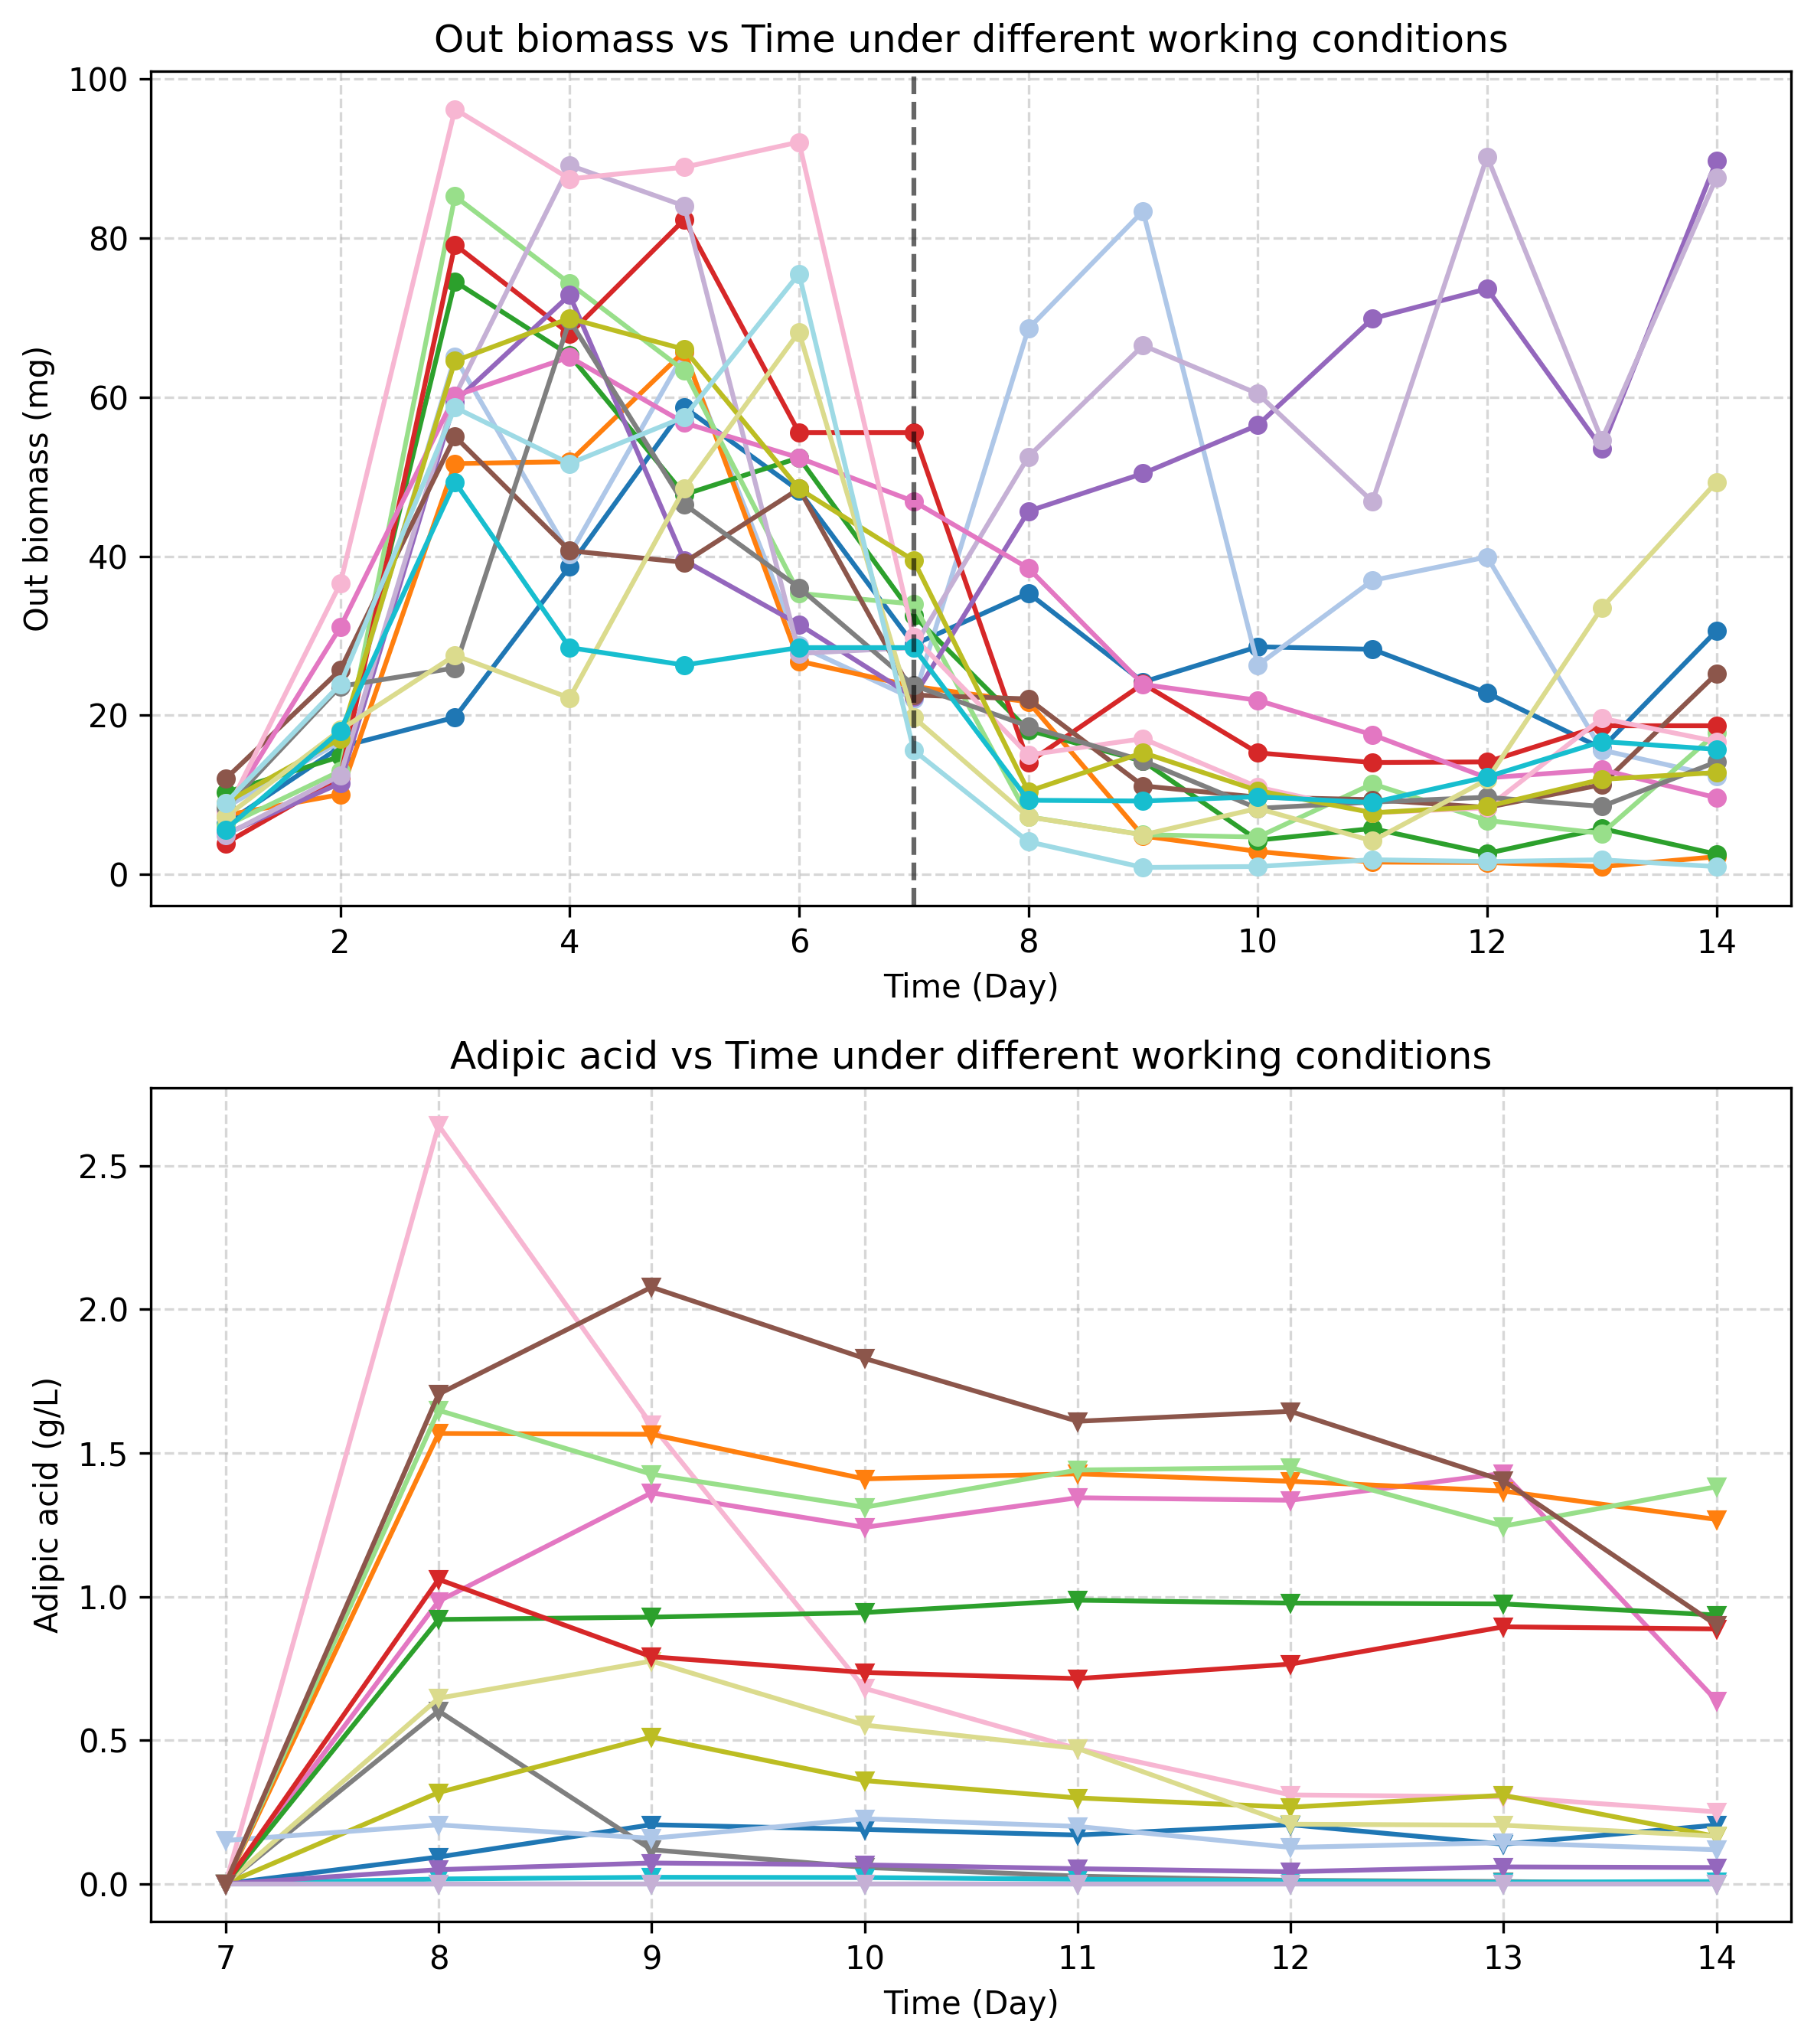

In [101]:
fig, axes = plt.subplots(2, 1, figsize=(8, 9), dpi=300)

reactor_names = sorted(bioreactor_df['reactor'].unique(), key=lambda x: int(x.split('_')[1]))

colors = cm.tab20(np.linspace(0, 1, len(reactor_names)))
color_map = dict(zip(reactor_names, colors))

# Adipic acid vs time
for reactor, group in bioreactor_df.groupby("reactor"):
    axes[1].plot(
        group['time'] + 6,
        group['adipic_acid'],
        label=reactor,
        color=color_map[reactor],
        marker='v',
        markersize=5
    )

# Biomass vs time
df_clean = bioreactor_lostbm_df.iloc[:14]
time = range(1, 15)
reactor_data = df_clean.drop(columns=df_clean.columns[0])

ordered_columns = sorted(reactor_data.columns, key=lambda x: int(x.split('_')[1]))

for column in ordered_columns:
    color = color_map.get(column, 'gray')
    axes[0].plot(
        time,
        reactor_data[column],
        label=column,
        color=color,
        marker='o',
        markersize=5)

# Inoculation
axes[0].axvline(7, linestyle='--', color='black', alpha=0.6, label='Inoculation')

axes[1].set_xlabel("Time (Day)")
axes[1].set_ylabel("Adipic acid (g/L)")
axes[1].set_title("Adipic acid vs Time under different working conditions")
axes[1].grid(True, alpha=0.5, linestyle='--')

axes[0].set_xlabel("Time (Day)")
axes[0].set_ylabel("Out biomass (mg)")
axes[0].set_title("Out biomass vs Time under different working conditions")
axes[0].grid(True, alpha=0.5, linestyle='--')

#fig.legend(reactor_names, bbox_to_anchor=(1., 0.5), loc='center left', title='Reactors')

plt.tight_layout()
plt.show()

## Correlations

Here we select a point in time where Adipic acid production seems to have reached a stable state and study the correlations of the stable state with respect to the bioreactor working conditions

======================================== Adipic Acid Correlations with input variables ========================================


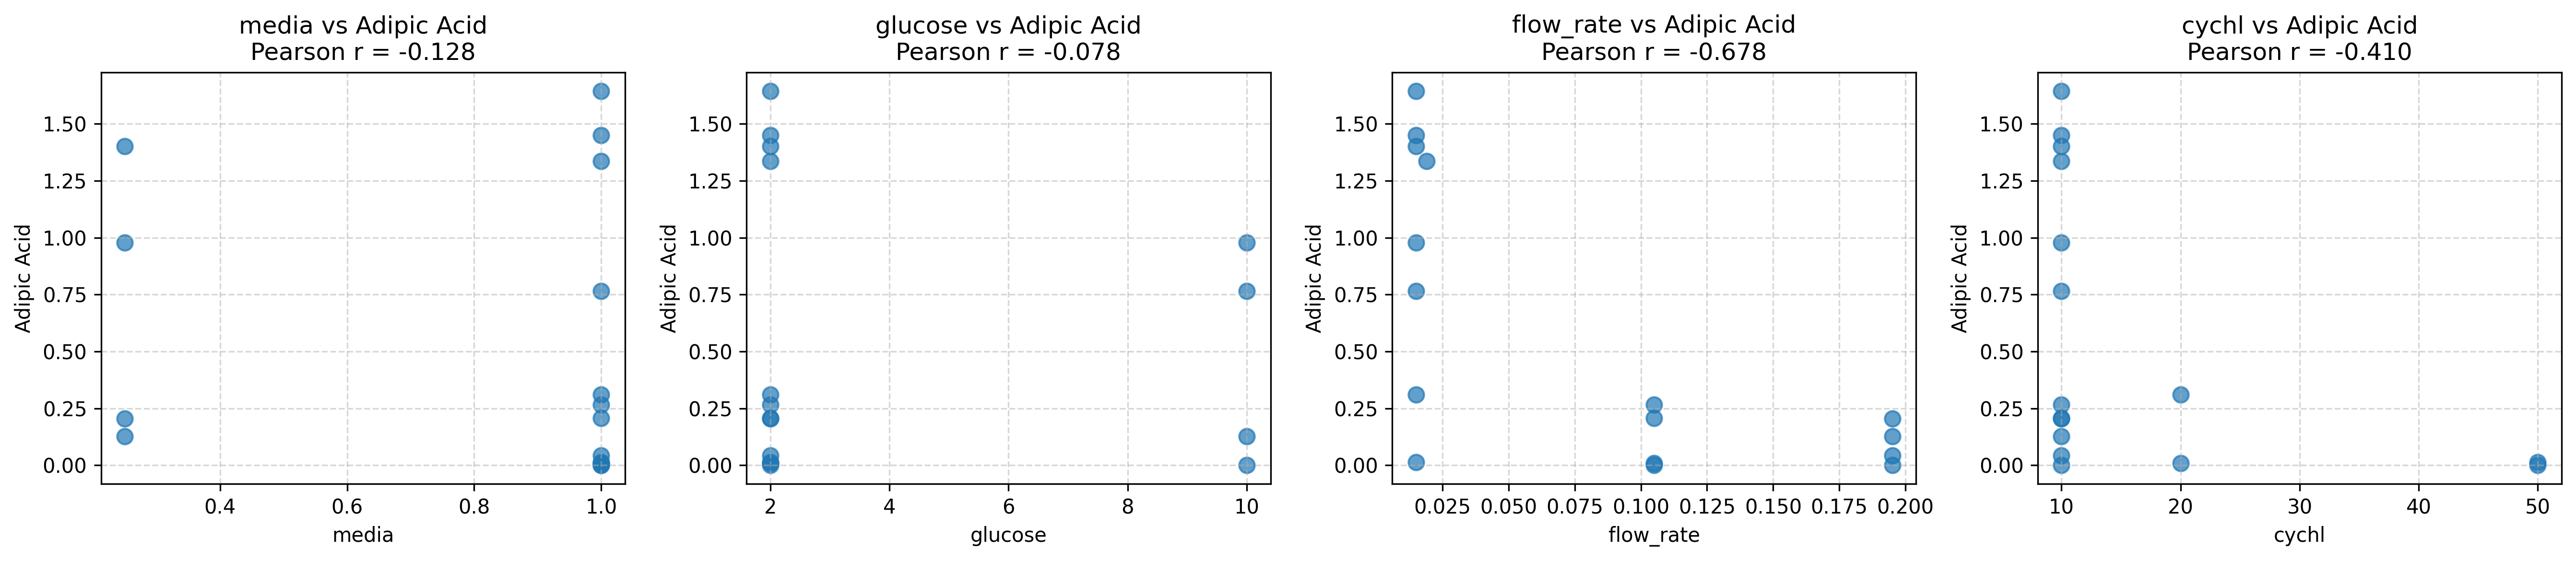

Pearson Correlation Coefficients:
media      vs Adipic Acid: r = -0.128 (p = 0.637)
glucose    vs Adipic Acid: r = -0.078 (p = 0.774)
flow_rate  vs Adipic Acid: r = -0.678 (p = 0.004)
cychl      vs Adipic Acid: r = -0.410 (p = 0.115)


======================================== Out-Biomass Correlations with input variables ========================================


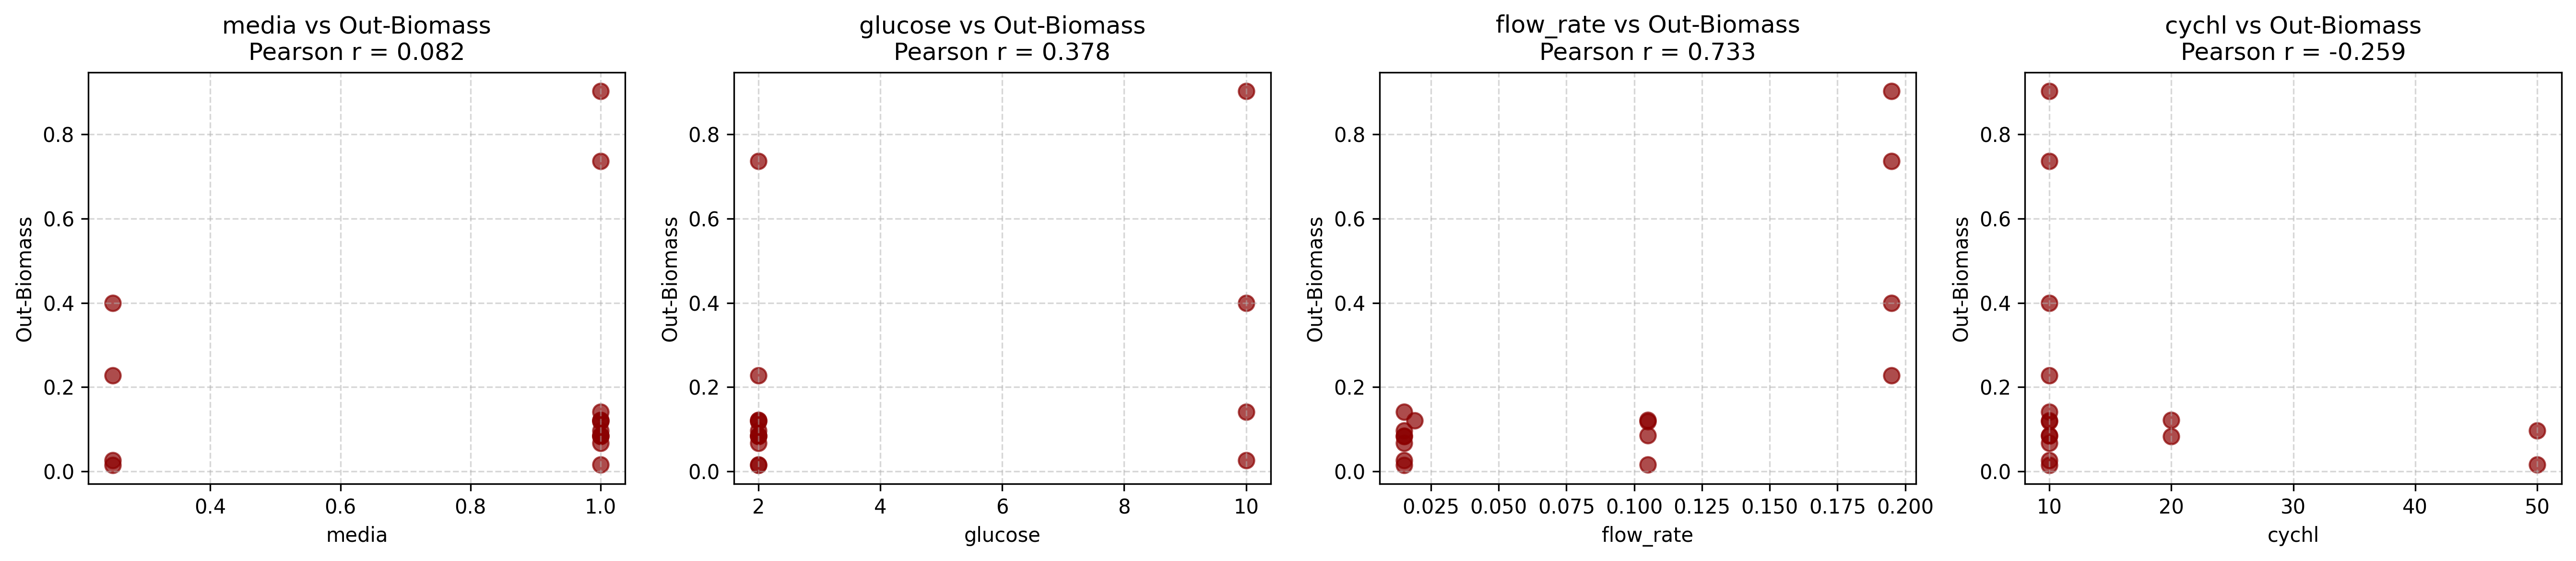

Pearson Correlation Coefficients:
media      vs Out-Biomass: r = 0.082 (p = 0.762)
glucose    vs Out-Biomass: r = 0.378 (p = 0.149)
flow_rate  vs Out-Biomass: r = 0.733 (p = 0.001)
cychl      vs Out-Biomass: r = -0.259 (p = 0.333)


In [102]:
df = bioreactor_df.drop('out_biomass', axis=1)
df = df.drop('reactor', axis=1)
df = df.drop('flow_rate_microL', axis=1)
stable_df = df.loc[df['time'] == 6]
stable_aa_df = stable_df.drop('time', axis=1).drop('out_biomas_dg', axis=1)
stable_bm_df = stable_df.drop('time', axis=1).drop('adipic_acid', axis=1)

variables = ['media', 'glucose', 'flow_rate', 'cychl']
target_aa = 'adipic_acid'
target_bm = 'out_biomas_dg'

# Adipic acid
target_var = target_aa
df = stable_aa_df

print("="*40 + " Adipic Acid Correlations with input variables " + "="*40)
fig, axes = plt.subplots(1, 4, figsize=(18, 4), dpi=300)
#axes = axes.flatten()

# Create scatter plots with correlation coefficients
for i, var in enumerate(variables):
    # Calculate Pearson correlation
    corr_coef, p_value = pearsonr(df[var], df[target_var])
    
    # Create scatter plot
    axes[i].scatter(df[var], df[target_var], alpha=0.7, s=60)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Adipic Acid')
    axes[i].set_title(f'{var} vs Adipic Acid\nPearson r = {corr_coef:.3f}')
    
    # Add grid for better readability
    axes[i].grid(True, linestyle = '--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print correlation coefficients
print("Pearson Correlation Coefficients:")
print("=" * 40)
for var in variables:
    corr_coef, p_value = pearsonr(df[var], df[target_var])
    print(f"{var:10} vs Adipic Acid: r = {corr_coef:.3f} (p = {p_value:.3f})")
print('\n')


# Biomass
target_var = target_bm
df = stable_bm_df

print("="*40 + " Out-Biomass Correlations with input variables " + "="*40)
fig, axes = plt.subplots(1, 4, figsize=(18, 4), dpi=300)
#axes = axes.flatten()

# Create scatter plots with correlation coefficients
for i, var in enumerate(variables):
    # Calculate Pearson correlation
    corr_coef, p_value = pearsonr(df[var], df[target_var])
    
    # Create scatter plot
    axes[i].scatter(df[var], df[target_var], alpha=0.7, s=60, c='darkred')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Out-Biomass')
    axes[i].set_title(f'{var} vs Out-Biomass\nPearson r = {corr_coef:.3f}')
    
    # Add grid for better readability
    axes[i].grid(True, linestyle = '--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print correlation coefficients
print("Pearson Correlation Coefficients:")
print("=" * 40)
for var in variables:
    corr_coef, p_value = pearsonr(df[var], df[target_var])
    print(f"{var:10} vs Out-Biomass: r = {corr_coef:.3f} (p = {p_value:.3f})")

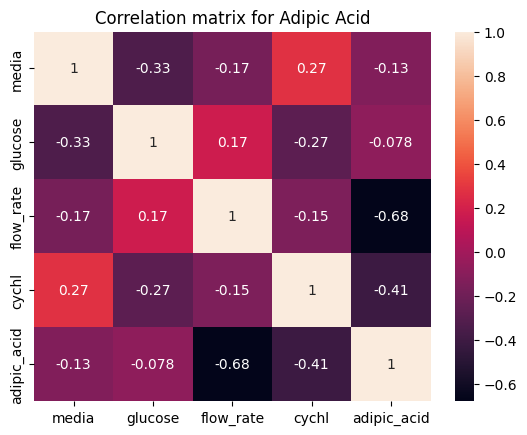

In [103]:
stable_aa_df.columns
sns.heatmap(stable_aa_df.corr(), annot=True)
plt.title('Correlation matrix for Adipic Acid');

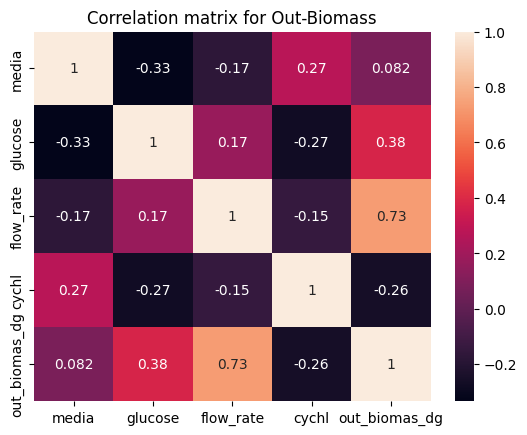

In [104]:
stable_bm_df.columns
sns.heatmap(stable_bm_df.corr(), annot=True)
plt.title('Correlation matrix for Out-Biomass');

## Total produced biomass

Text(0, 0.5, 'Total biomass (mg)')

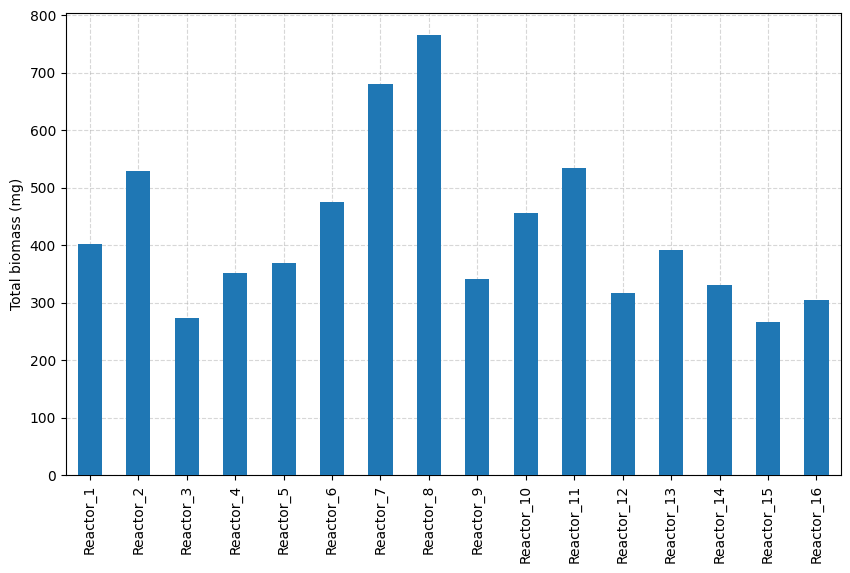

In [105]:
total_biomass = pd.DataFrame(bioreactor_lostbm_df.iloc[14]).iloc[1:]
total_biomass.plot(kind='bar', figsize=(10,6), legend=False, zorder=10)
plt.grid(True, zorder=0, linestyle='--', alpha=0.5)
plt.ylabel('Total biomass (mg)')

# Aditional Dataset (27-days)
An aditional dataset of 8 bioractors was also provided. These bioreactors were run for 27 days. The Cychlohexanol was again inoculated at the end of the sixth day

In [106]:
bioreactor27d_df = pd.read_excel('BioreactorPsdmData27d.xlsx', sheet_name='bioreactors 27d')
bioreactor_lostbm27d_df = pd.read_excel('BioreactorPsdmData27d.xlsx', sheet_name='lost biomass 27d')
reactor_conditions = (bioreactor27d_df.groupby('reactor')[['media', 'glucose', 'flow_rate', 'cychl']].first().reset_index())
reactor_conditions = reactor_conditions.sort_values(by='reactor', key=lambda x: x.str.extract(r'(\d+)').iloc[:, 0].astype(int)).reset_index(drop=True)

## Summary of reactor conditions

| Reactor | Media | Glucose [g/L]| Flow Rate [mL/min] | Cychlohexanol [mM]|
| --- | --- | --- | --- | --- |
| 1 | 0.25 | 0.5 | 0.015 | 10 |
| 2 | 0.25 | 0.5 | 0.015 | 10 |
| 3 | 0.25 | 2.0 | 0.015 | 10 |
| 4 | 0.25 | 2.0 | 0.015 | 10 |
| 5 | 1.00 | 0.5 | 0.015 | 10 |
| 6 | 1.00 | 0.5 | 0.015 | 10 |
| 7 | 1.00 | 2.0 | 0.015 | 10 |
| 8 | 1.00 | 2.0 | 0.015 | 10 |

## Adipic acid and Out-biomass time series

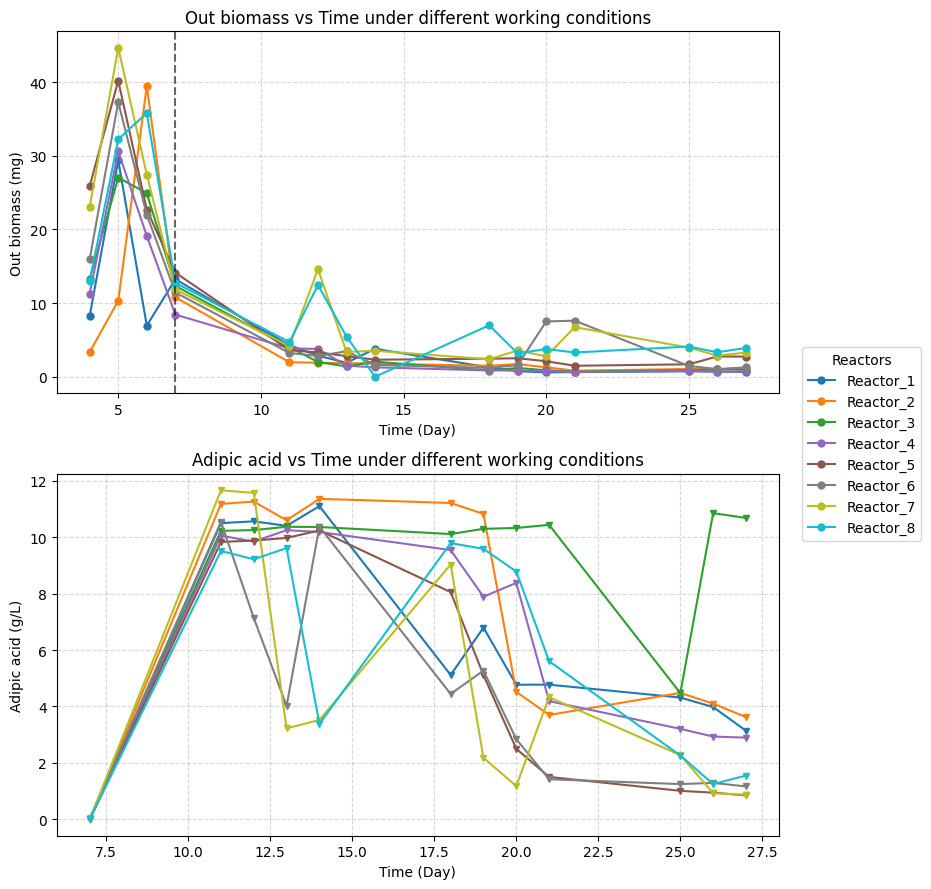

In [107]:
fig, axes = plt.subplots(2, 1, figsize=(8, 9))

reactor_names = sorted(bioreactor27d_df['reactor'].unique(), key=lambda x: int(x.split('_')[1]))

colors = cm.tab10(np.linspace(0, 1, len(reactor_names)))
color_map = dict(zip(reactor_names, colors))

# Adipic acid vs time
for reactor, group in bioreactor27d_df.groupby("reactor"):
    axes[1].plot(
        group['time'],
        group['adipic_acid'],
        label=reactor,
        color=color_map[reactor],
        marker='v',
        markersize=5
    )

# Biomass vs time
df_clean = bioreactor_lostbm27d_df.iloc[:15]
time = [4,5,6,7,11,12,13,14,18,19,20,21,25,26,27]
reactor_data = df_clean.drop(columns=df_clean.columns[0])

ordered_columns = reactor_data.columns

for column in ordered_columns:
    color = color_map.get(column, 'gray')
    axes[0].plot(
        time,
        reactor_data[column],
        label=column,
        color=color,
        marker='o',
        markersize=5)

# Inoculation
axes[0].axvline(7, linestyle='--', color='black', alpha=0.6, label='Inoculation')

axes[1].set_xlabel("Time (Day)")
axes[1].set_ylabel("Adipic acid (g/L)")
axes[1].set_title("Adipic acid vs Time under different working conditions")
axes[1].grid(True, alpha=0.5, linestyle='--')

axes[0].set_xlabel("Time (Day)")
axes[0].set_ylabel("Out biomass (mg)")
axes[0].set_title("Out biomass vs Time under different working conditions")
axes[0].grid(True, alpha=0.5, linestyle='--')

fig.legend(reactor_names, bbox_to_anchor=(1., 0.5), loc='center left', title='Reactors')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Total biomass (mg)')

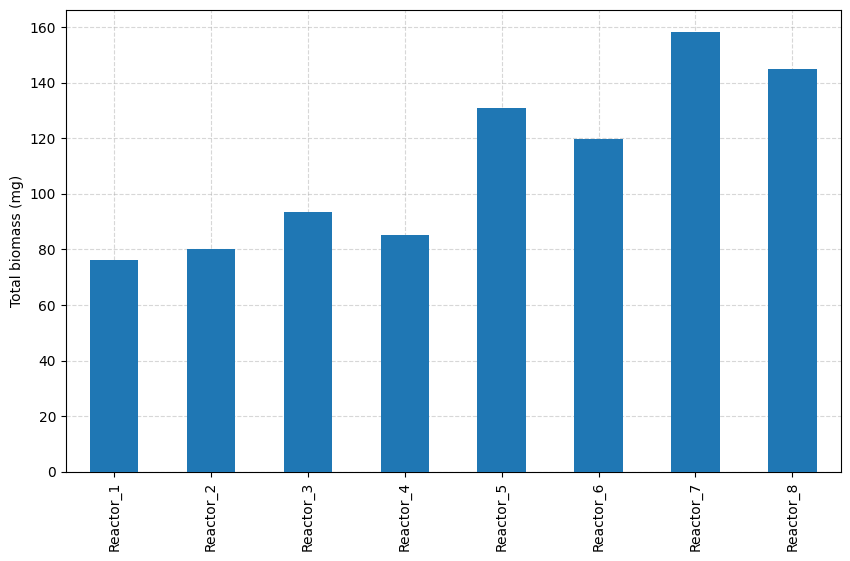

In [108]:
total_biomass = pd.DataFrame(bioreactor_lostbm27d_df.iloc[15]).iloc[1:]
total_biomass.plot(kind='bar', figsize=(10,6), legend=False, zorder=10)
plt.grid(True, zorder=0, linestyle='--', alpha=0.5)
plt.ylabel('Total biomass (mg)')